In [1]:
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from lightning.pytorch.callbacks import ProgressBar
from torchmetrics.functional import dice, f1_score, jaccard_index
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import accuracy_score, roc_auc_score


# config
config = {
    "wandb": True,
    'competition'   : 'rsna-atd' ,
    '_wandb_kernel' : 'johnnyhyl',
    "data_path": "../",
    "model": {
        "encoder_name": 'resnet50',
        "loss_smooth": 1.0,
        "loss": nn.BCEWithLogitsLoss(),
        "optimizer_params": {"lr": 0.01, "weight_decay": 0.0},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 20, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.316,
                    "mode": "min",
                    "patience": 3,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 10,
    "seed": 42,
    "train_bs": 32,
    "use_aug": False,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 15,
        "min_epochs": 8,
        "accelerator": "mps",
        "devices": 1,
    },
    "valid_bs": 32,
    "workers": 0,
    "device": "mps",
    "folds": {
        "n_splits": 4,
        "random_state": 42,
        "train_folds": [0, 1, 2, 3]
    },
    'target_col': [ "bowel_injury", 
                   "extravasation_injury", 
                #    "kidney_healthy", 
                   "kidney_low",
                   "kidney_high", 
                #    "liver_healthy", 
                   "liver_low", "liver_high",
                #    "spleen_healthy", 
                   "spleen_low", "spleen_high"],
}


/Users/johnny/anaconda3/envs/kag2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = '.'

# val
df = pd.read_csv(f"{BASE_PATH}/train.csv")
df["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + df.patient_id.astype(str)\
                    + "/" + df.series_id.astype(str)\
                    + "/" + df.instance_number.astype(str) +".png"
df = df.drop_duplicates()

df.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,./train_images/10004/21057/362.png,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,./train_images/10004/21057/363.png,512,512


In [3]:
filepath = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/segmentations/'
filenames = os.listdir(filepath)
# extract the series id from the file names *.nii
segs = [int(x.split('.')[0]) for x in filenames]
# check what series id are in df.series_id
segs_in_train = [x for x in segs if x in df.series_id.unique()]

seg_df = pd.DataFrame()
seg_df['series_id'] = segs_in_train
def get_patient_id(series_id):
    matching_patient_ids = df[df['series_id'] == series_id]['patient_id'].unique()
    return matching_patient_ids[0] if len(matching_patient_ids) > 0 else None

seg_df['patient_id'] = seg_df['series_id'].apply(get_patient_id)
seg_df["dicom_folder"] = f"{BASE_PATH}/dicom/train_images"\
                    + "/" + seg_df.patient_id.astype(str)\
                    + "/" + seg_df.series_id.astype(str)
seg_df['seg_path'] = f"{BASE_PATH}/segmentations/" + seg_df['series_id'].astype(str) + ".nii"

In [4]:
seg_df

,series_id,patient_id,dicom_folder,seg_path
0,60961,38541,./dicom/train_images/38541/60961,./segmentations/60961.nii
1,40496,24524,./dicom/train_images/24524/40496,./segmentations/40496.nii
2,5260,36289,./dicom/train_images/36289/5260,./segmentations/5260.nii
3,6344,44693,./dicom/train_images/44693/6344,./segmentations/6344.nii
4,5103,41306,./dicom/train_images/41306/5103,./segmentations/5103.nii
...,...,...,...,...
81,28122,50820,./dicom/train_images/50820/28122,./segmentations/28122.nii
82,39013,11652,./dicom/train_images/11652/39013,./segmentations/39013.nii
83,5118,31636,./dicom/train_images/31636/5118,./segmentations/5118.nii
84,39205,15117,./dicom/train_images/15117/39205,./segmentations/39205.nii


In [5]:
import nibabel as nib
import pydicom as dicom
import os
from tqdm import tqdm

def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    for filename in tqdm(filenames[::downsample_rate]):
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume


def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img

def get_image_with_seg(volume, volume_seg):

    slices = np.linspace(0, volume.shape[0]-1, len(volume_seg)).astype(np.int16)

    images = []
    masks = []

    for this_slice in slices:
        image = volume[this_slice, :, :]

        mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)

        images.append(image)
        masks.append(mask)

    return images, masks

def get_image(volume):
    
        slices = np.linspace(0, volume.shape[0]-1, 200).astype(np.int16)
    
        images = []
    
        for this_slice in slices:
            image = volume[this_slice, :, :]
    
            images.append(image)
    
        return images


# volume_seg = create_3D_segmentations(seg_df.seg_path[0], downsample_rate=1)
# print(f'3D segmentation file shape: {volume_seg.shape}')

# volume = create_3D_scans(seg_df.dicom_folder[0], downsample_rate=1)
# print(f'3D Image file shape: {volume.shape}')

# images, masks = get_image_with_seg(volume, volume_seg)

In [6]:
# output_folder = "seg_train"
# os.makedirs(output_folder, exist_ok=True)

# file_counter = 1  # To name the files incrementally

# for idx, row in tqdm(seg_df.iterrows(), total=len(seg_df)):
#     volume_seg = create_3D_segmentations(row['seg_path'])
#     volume = create_3D_scans(row['dicom_folder'])
#     images, masks = get_image_with_seg(volume, volume_seg)
    
#     for img, msk in zip(images, masks):
#         stacked_data = np.stack([img, msk], axis=0)  # stack image and mask along the first dimension
#         output_path = os.path.join(output_folder, f"{file_counter}.npy")
#         np.save(output_path, stacked_data)
#         file_counter += 1

In [7]:
# # plot the image and mask
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# ax[0].imshow(images[100], cmap='gray')
# ax[1].imshow(images[100], cmap='gray')
# ax[1].imshow(masks[100], cmap='Set1', alpha=0.5)
# plt.show()

In [8]:
# volume_seg = create_3D_segmentations(seg_df['seg_path'][0])
# volume = create_3D_scans(seg_df['dicom_folder'][0])
# images, masks = get_image_with_seg(volume, volume_seg)
# dumm = masks
# # fill na with 0 in dumm
# # dumm = np.nan_to_num(dumm)
# np.unique(dumm)

In [9]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import albumentations as A
from PIL import Image

class AbdominalTraumaDataset(Dataset):
    def __init__(self, file_list, use_augmentations=None):
        """
        Args:
            root_dir (string): Directory with all the .npy files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.file_list = file_list
        self.use_augmentations = use_augmentations
        self.root_dir = 'seg_train'
        self.resize_image = T.transforms.Resize([256,256])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        sample = np.load(img_name)
        
        image, mask = sample[0], sample[1]
        
        # Convert numpy arrays to PIL Images
        image = Image.fromarray(image.astype(np.uint8))
        mask = Image.fromarray(mask.astype(np.uint8))
        
        # Apply transforms
        image = self.resize_image(image)
        mask = self.resize_image(mask)

        # Convert PIL Images to Tensors
        image = T.functional.to_tensor(image)
        mask = T.functional.to_tensor(mask)

        # mask = F.one_hot(mask.squeeze(0).long(), num_classes=5)  # shape [height, width, 5]
        # mask = mask.permute(2, 0, 1).float()  # shape [5, height, width]
        mask = (mask >= 1).float()


        return image, mask


* All the images **should** be the same orientation.
* Applying flips might weaken the model as it can reasonably expect a certain orientation
* some people have situs inversus (rare)
* if the trauma is bad the person might not by lying straight, so there may be a clue in their having trauma from the angle of the image
* applying radom rotations might destroy this information

In [12]:
import segmentation_models_pytorch as smp

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # logits = torch.sigmoid(logits)

        # flatten label and prediction tensors
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        return 1 - (2.0 * intersection + self.smooth) / (
            logits.sum() + targets.sum() + self.smooth
        )

class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights=None,
            in_channels=1,
            classes=1,
            activation=None,
        )

        self.loss_module = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        logits = self.model(imgs)
        return torch.sigmoid(logits)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        # labels = labels.unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=config["train_bs"])

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        # labels = labels.unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

In [13]:
import warnings
import gc

warnings.filterwarnings("ignore")

import os
import torch
import pandas as pd
import lightning.pytorch as pl
from pprint import pprint
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch import mps
from sklearn.model_selection import StratifiedGroupKFold
# 1621
file_list = [f for f in os.listdir('seg_train') if f.endswith('.npy')]
train_list = file_list[:1621]
valid_list = file_list[1621:]

if config["use_aug"] == True:
    transform_set = A.Compose([A.VerticalFlip(p=0.5),
                            A.HorizontalFlip(p=0.5),
                            A.RandomRotate90(p=0.5)])
else:
    transform_set = None

dataset_train = AbdominalTraumaDataset(train_list, use_augmentations=None)
dataset_validation = AbdominalTraumaDataset(valid_list, use_augmentations=None)

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=True, num_workers=config["workers"]
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=True, num_workers=config["workers"]
)

pl.seed_everything(config["seed"])

filename = "seg_model"

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=config["output_dir"],
    mode="min",
    filename=filename,
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(refresh_rate=config["progress_bar_refresh_rate"])

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

wandb_logger = WandbLogger(log_model="all")

trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger=wandb_logger, **config["trainer"]
)

model = LightningModule(config['model'])

trainer.fit(model, data_loader_train, data_loader_validation)

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name        | Type              | Params
--------------------------------------------------
0 | model       | Unet              | 32.5 M
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.059   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 51/51 [03:42<00:00,  4.36s/it, v_num=x0m1, train_loss_step=0.000704, lr=0.005, val_loss=0.00104, train_loss_epoch=0.0285]

Metric val_loss improved. New best score: 0.001
Epoch 0, global step 51: 'val_loss' reached 0.00104 (best 0.00104), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 1: 100%|██████████| 51/51 [03:16<00:00,  3.85s/it, v_num=x0m1, train_loss_step=0.000419, lr=6.26e-5, val_loss=0.000438, train_loss_epoch=0.000541]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000
Epoch 1, global step 102: 'val_loss' reached 0.00044 (best 0.00044), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 2: 100%|██████████| 51/51 [03:14<00:00,  3.81s/it, v_num=x0m1, train_loss_step=0.000282, lr=0.00655, val_loss=0.000286, train_loss_epoch=0.000336]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 2, global step 153: 'val_loss' reached 0.00029 (best 0.00029), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 3: 100%|██████████| 51/51 [03:13<00:00,  3.80s/it, v_num=x0m1, train_loss_step=0.000186, lr=0.00946, val_loss=0.000193, train_loss_epoch=0.000226]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 3, global step 204: 'val_loss' reached 0.00019 (best 0.00019), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 4: 100%|██████████| 51/51 [03:13<00:00,  3.80s/it, v_num=x0m1, train_loss_step=0.000135, lr=0.00206, val_loss=0.000141, train_loss_epoch=0.000162] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 4, global step 255: 'val_loss' reached 0.00014 (best 0.00014), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 5: 100%|██████████| 51/51 [03:13<00:00,  3.80s/it, v_num=x0m1, train_loss_step=0.000108, lr=0.00147, val_loss=0.000111, train_loss_epoch=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 5, global step 306: 'val_loss' reached 0.00011 (best 0.00011), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 6: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=8.75e-5, lr=0.00905, val_loss=8.65e-5, train_loss_epoch=9.71e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 6, global step 357: 'val_loss' reached 0.00009 (best 0.00009), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 7: 100%|██████████| 51/51 [03:16<00:00,  3.86s/it, v_num=x0m1, train_loss_step=6.93e-5, lr=0.00727, val_loss=7.11e-5, train_loss_epoch=7.75e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 7, global step 408: 'val_loss' reached 0.00007 (best 0.00007), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 8: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=6.16e-5, lr=0.000246, val_loss=5.89e-5, train_loss_epoch=6.41e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 8, global step 459: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 9: 100%|██████████| 51/51 [03:17<00:00,  3.86s/it, v_num=x0m1, train_loss_step=5.02e-5, lr=0.00422, val_loss=5.03e-5, train_loss_epoch=5.41e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 9, global step 510: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 10: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=4.19e-5, lr=0.010, val_loss=4.27e-5, train_loss_epoch=4.59e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 10, global step 561: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 11: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=3.65e-5, lr=0.00422, val_loss=3.7e-5, train_loss_epoch=3.93e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 11, global step 612: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 12: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=3.29e-5, lr=0.000246, val_loss=3.23e-5, train_loss_epoch=3.42e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 12, global step 663: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 13: 100%|██████████| 51/51 [03:18<00:00,  3.89s/it, v_num=x0m1, train_loss_step=2.84e-5, lr=0.00727, val_loss=2.87e-5, train_loss_epoch=3.02e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 13, global step 714: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1


Epoch 14: 100%|██████████| 51/51 [03:17<00:00,  3.87s/it, v_num=x0m1, train_loss_step=2.47e-5, lr=0.00905, val_loss=2.48e-5, train_loss_epoch=2.66e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 14, global step 765: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 51/51 [03:18<00:00,  3.90s/it, v_num=x0m1, train_loss_step=2.47e-5, lr=0.00905, val_loss=2.48e-5, train_loss_epoch=2.66e-5]


In [14]:
checkpoint_callback.best_model_path

'/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/models/seg_model-v5.ckpt'

torch.Size([1, 1, 256, 256])


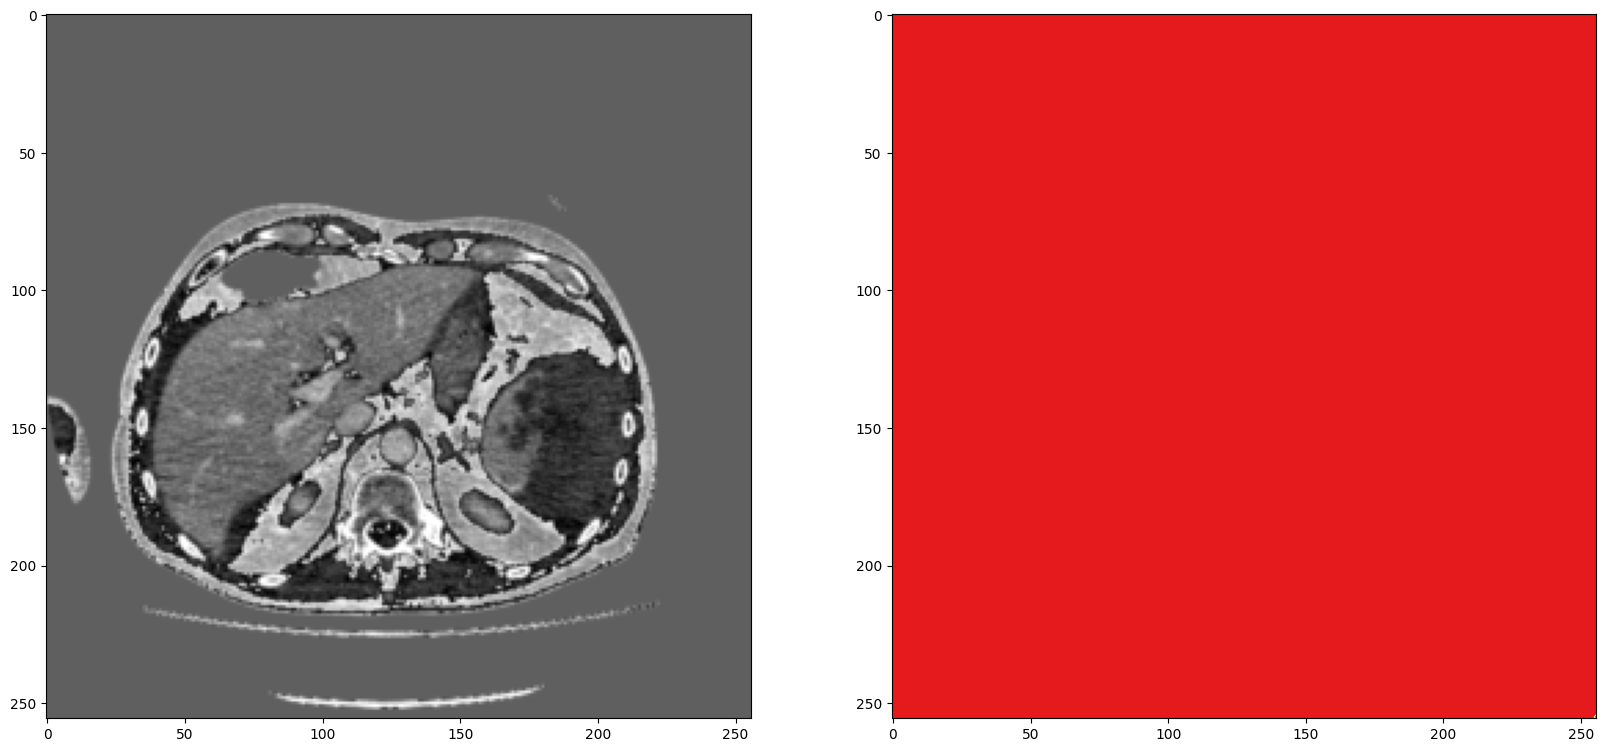

In [19]:
# Load the checkpoint
model = LightningModule.load_from_checkpoint(checkpoint_callback.best_model_path, config=config['model'])
model = model.to('cpu')
model.eval()

path = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/seg_train/500.npy'

sample = np.load(path)
image = sample[0]
# Convert numpy arrays to PIL Images
image = Image.fromarray(image.astype(np.uint8))

# Apply transforms
resize_image = T.transforms.Resize([256,256])
image = resize_image(image)

# Convert PIL Images to Tensors
image_tensor = T.functional.to_tensor(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Predict
with torch.no_grad():
    pred = model(image_tensor)
    print(pred.shape)

# Get class labels from the prediction tensor
labels = pred.squeeze(0).squeeze(0).cpu().numpy()

# lab = pred.squeeze(0).squeeze(0).cpu().numpy()
threshold = 0.0009
lab = (labels > threshold)

# Convert the tensor image back to numpy for visualization
img_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert [C, H, W] to [H, W, C]

# Plot the original image and the predicted segmentation mask
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_np, cmap='gray')
# ax[1].imshow(img_np, cmap='gray')
ax[1].imshow(lab, cmap='Set1')
# ax[1].imshow(labels, cmap='Set1', alpha=0.5)
plt.show()

In [18]:
pred.max()

tensor(0.0012)

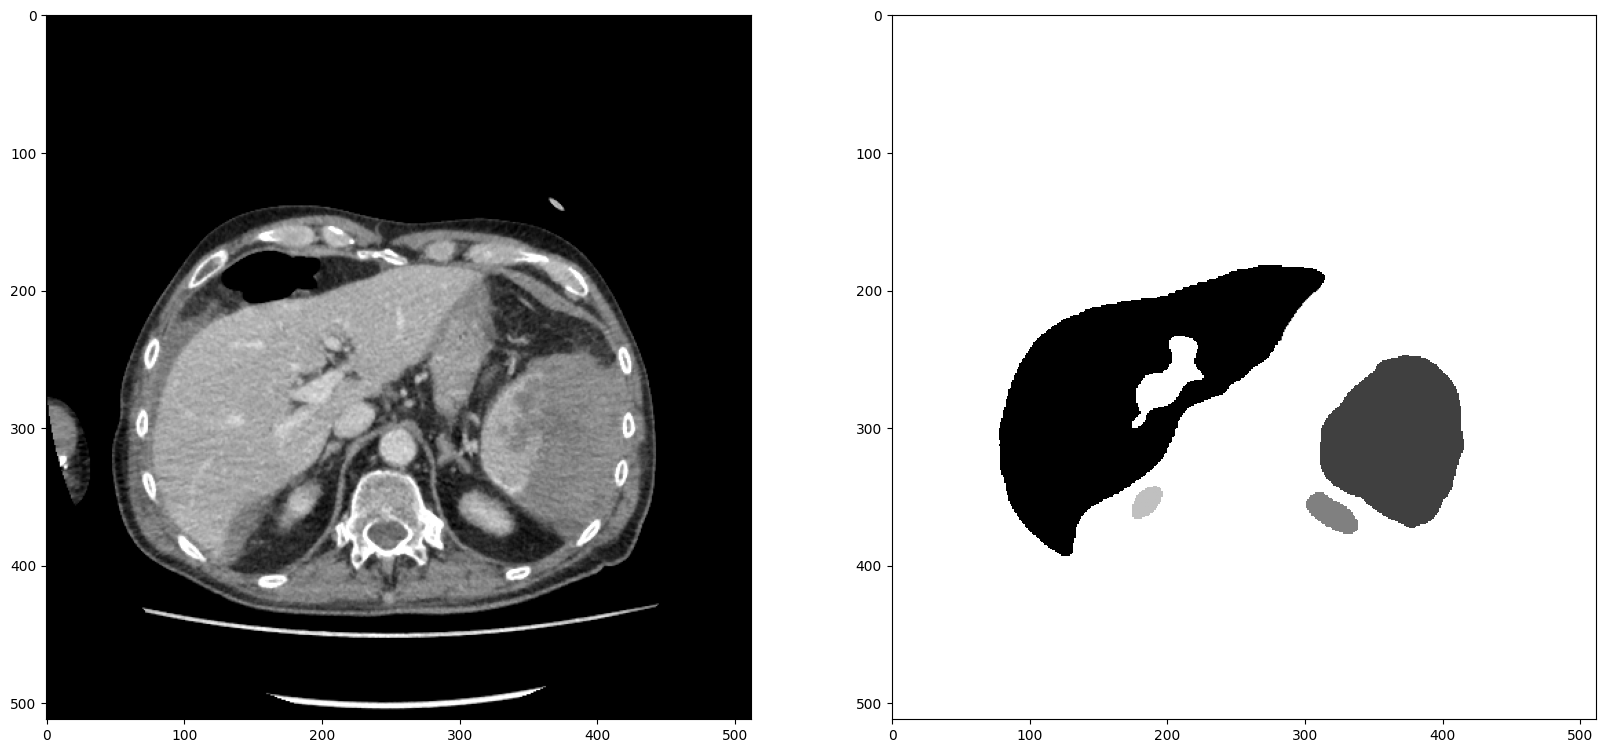

In [55]:
path = '/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/ab_trauma/seg_train/500.npy'

sample = np.load(path)
image, mask = sample[0], sample[1]

# plot images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(mask, cmap='gray')